In [20]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import os
import matplotlib.pyplot as plt
import random as rd
import pandas as pd
import numpy as np
from tqdm import tqdm
import time
from analyze_data import calculate_gini_coefficient
from plots import plot_Lorenz, plot_data_distribution

from collections import defaultdict
from scipy import stats
from numpy.linalg import norm
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
# set plot style: grey grid in the background:
sns.set(style="darkgrid")
pd.set_option("display.precision", 8)

# Set hyperparameters

In [2]:
my_seed = 0
predict_col = "rating"
top_fraction = 0.2

rd.seed(my_seed) #seed for random functions
np.random.seed(my_seed) #seed for all numpy stuff


# Functions

In [3]:
def users_and_items(df_events, user_col, item_col):
    print('No. user events: ' + str(len(df_events)))
    print('No. items: ' + str(len(df_events[item_col].unique())))
    print('No. users: ' + str(len(df_events[user_col].unique())))
    print("\n")
def user_distribution(df_events, user_col, item_col):
    user_dist = df_events[user_col].value_counts() 
    num_users = len(user_dist)
    print('Mean '+item_col+'s per user: ' + str(np.round(user_dist.mean(),1))) 
    print('Min '+item_col+'s per user: ' + str(np.round(user_dist.min(),1))) 
    print('Max '+item_col+'s per user: ' + str(np.round(user_dist.max(),1)))
    print("\n")
    return user_dist, num_users
def item_distribution(df_events, user_col, item_col):
    item_dist = df_events[item_col].value_counts()
    num_items = len(item_dist)
    print('Mean users per '+item_col+': ' + str(np.round(item_dist.mean(),1))) 
    print('Min users per '+item_col+': ' + str(np.round(item_dist.min(),1))) 
    print('Max users per '+item_col+': ' + str(np.round(item_dist.max(),1))) 
    print("\n")
    return item_dist, num_items

# Read & process data

### Movie data

In [4]:
user_events_file = 'https://raw.githubusercontent.com/SavvinaDaniil/UnfairnessOfPopularityBias/main/data/ratings_movies.dat'

# read user events
cols = ['user', 'movie', 'rating', 'timestamp']
df_events_movies = pd.read_table(user_events_file, sep = "::", engine="python", names=cols)
item_col = "movie"
print('No. of user events: ' + str(len(df_events_movies)))

No. of user events: 1000209


In [5]:
users_and_items(df_events_movies, "user", item_col)
user_dist_movies, num_users_movies = user_distribution(df_events_movies, "user", item_col)
item_dist_movies, num_items_movies = item_distribution(df_events_movies, "user", item_col)

No. user events: 1000209
No. items: 3706
No. users: 6040


Mean movies per user: 165.6
Min movies per user: 20
Max movies per user: 2314


Mean users per movie: 269.9
Min users per movie: 1
Max users per movie: 3428




In [6]:
num_top_movies = int(top_fraction * num_items_movies)
top_item_dist_movies = item_dist_movies[:num_top_movies]
print('No. top movies: ' + str(len(top_item_dist_movies)))

No. top movies: 741


### Music data

In [7]:
user_events_file = 'https://media.githubusercontent.com/media/SavvinaDaniil/UnfairnessOfPopularityBias/main/data/ratings_music.txt'

# read user events
item_col = "artist"
cols = ['user',item_col, 'album', 'track', 'timestamp']
df_events_music = pd.read_csv(user_events_file, sep = '\t', names = cols)

print('No. of user events: ' + str(len(df_events_music)))

No. of user events: 28718087


In [8]:
# create user-item matrix
df_events_music = df_events_music.groupby(['user', item_col]).size().reset_index(name='rating')
print('No. user-item interactions: ' + str(len(df_events_music)))

No. user-item interactions: 1755361


In [9]:
df_events_music = df_events_music.astype("int")

In [10]:
users_and_items(df_events_music, "user", item_col)
user_dist_music, num_users_music = user_distribution(df_events_music, "user", item_col)
item_dist_music, num_items_music = item_distribution(df_events_music, "user", item_col)

No. user events: 1755361
No. items: 352805
No. users: 3000


Mean artists per user: 585.1
Min artists per user: 18
Max artists per user: 4011


Mean users per artist: 5.0
Min users per artist: 1
Max users per artist: 1389




In [11]:
num_top_music = int(top_fraction * num_items_music)
top_item_dist_music = item_dist_music[:num_top_music]
print('No. top artists: ' + str(len(top_item_dist_music)))

No. top artists: 70561


### Book data

In [12]:
user_events_file = 'https://raw.githubusercontent.com/SavvinaDaniil/UnfairnessOfPopularityBias/main/data/BX-Book-Ratings.csv'

# read user events
cols = ['user', 'book', 'rating']
df_events_books = pd.read_csv(user_events_file, sep=";", encoding="ISO-8859–1", names=cols, skiprows=1)
item_col = "book"
print('No. of user events: ' + str(len(df_events_books)))

No. of user events: 1149780


In [13]:
# This method return a dataframe in which the specified values are removed from a specific column. We can use it to generate the implicit/explicit dataset.
# To do this,  a can remove the 0 or 1-10 values from the `Book-Rating` column.
def filter_rows_by_values(df, col, values):
    return df[~df[col].isin(values)]
df_events_books = filter_rows_by_values(df_events_books, predict_col, [0])

In [14]:
uid_value_counts = df_events_books['user'].value_counts()
#To remove the users with fewer than 5 interaction we first count the number of interactino per user and add a new column (`Count`) in the dataframe.
# This column shows the number of interaction per user in the dataset
users_counts = uid_value_counts.to_dict() #converts to dictionary
df_events_books['Count'] = df_events_books['user'].map(users_counts)

In [15]:
df_events_books = filter_rows_by_values(df_events_books, "Count", list(range(200, max(df_events_books['Count']) + 1)))

In [16]:
user_interaction, item_interaction = 1, 1
df_events_books = df_events_books.copy()
while user_interaction != 0 or item_interaction != 0:
    uid_value_counts = df_events_books["user"].value_counts()
    user_interaction = uid_value_counts[uid_value_counts < 5].count()

    users_counts = df_events_books["user"].value_counts()
    users_counts = users_counts.to_dict() #converts to dictionary
    df_events_books['Count'] = df_events_books["user"].map(users_counts)

    df_events_books = filter_rows_by_values(df_events_books, "Count", list(range(5)))

    # item side fewer than ds_rate cheking
    bid_value_counts = df_events_books[item_col].value_counts()
    item_interaction = bid_value_counts[bid_value_counts < 5].count()

    items_counts = df_events_books[item_col].value_counts()
    items_counts = items_counts.to_dict() #converts to dictionary
    df_events_books['Count'] = df_events_books[item_col].map(items_counts)

    df_events_books = filter_rows_by_values(df_events_books, "Count", list(range(5)))

In [17]:
# final data statistics
users_and_items(df_events_books, "user", item_col)
user_dist_books, num_users_books = user_distribution(df_events_books, "user", item_col)
item_dist_books, num_items_books = item_distribution(df_events_books, "user", item_col)

No. user events: 88552
No. items: 6921
No. users: 6358


Mean books per user: 13.9
Min books per user: 5
Max books per user: 153


Mean users per book: 12.8
Min users per book: 5
Max users per book: 350




In [18]:
del(df_events_books["Count"])

In [19]:
num_top_books = int(top_fraction * num_items_books)
top_item_dist_books = item_dist_music[:num_top_books]
print('No. top books: ' + str(len(top_item_dist_books)))

No. top books: 1384


# Data distribution

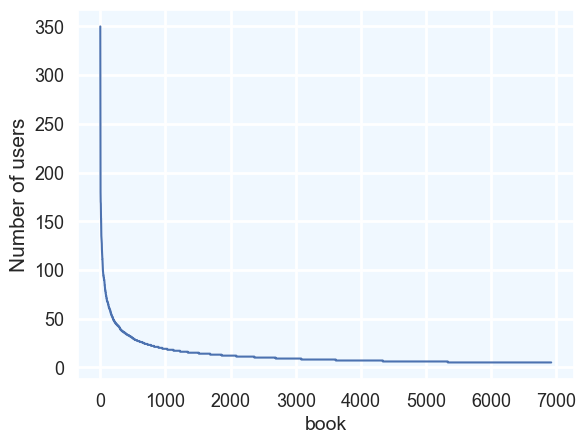

In [24]:
plot_data_distribution(item_dist_books, "book", dividing = [False, 0], log = False, save = True, addition = "_book")

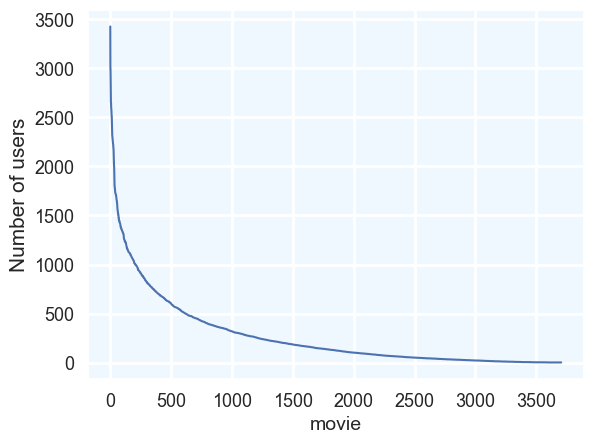

In [28]:
plot_data_distribution(item_dist_movies, "movie", dividing = [False, 0], log = False, save = True, addition = "_movie")

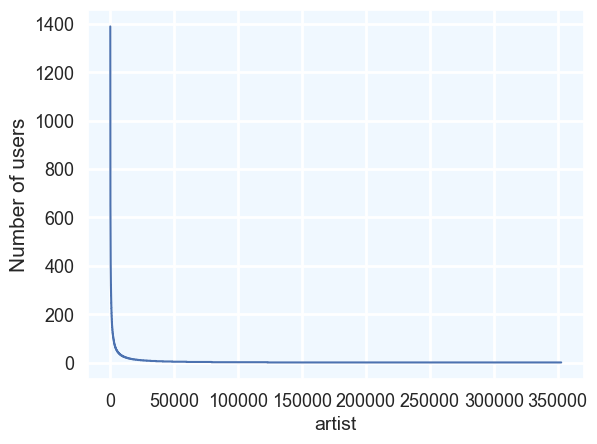

In [29]:
plot_data_distribution(item_dist_music, "artist", dividing = [False, 0], log = False, save = True, addition = "_music")

In [20]:
def plot_data_distribution_together(item_dist_list, item_list,item_col = "item", dividing = [False, 0], save = False, addition = ""):
    plt.figure()
    ax = plt.axes()
    ax.spines['bottom'].set_color('w')
    ax.spines['top'].set_color('w')
    ax.spines['right'].set_color('w')
    ax.spines['left'].set_color('w')
    ax.spines['left'].set_zorder(0)
    ax.xaxis.set_ticks_position('none') 
    ax.yaxis.set_ticks_position('none') 
    ax.set_facecolor("aliceblue")
    plt.grid(color = "w",linewidth = 2 )
    
    if dividing[0]:
        x0 = int(len(item_dist.values)*dividing[1])
        y = range(len(item_dist))
        plt.plot(y[:x0+1], item_dist.values[:x0+1], label = "Popular "+item_col+"s", linewidth = 5)
        plt.plot(y[x0:], item_dist.values[x0:], label = "Non Popular "+item_col+"s", linewidth = 5)
    else:
        i=0
        for item_dist in item_dist_list:
            
            plt.plot(item_dist.values, label = item_list[i])
            i+=1
    plt.legend()
    plt.xticks(fontsize='13')
    plt.yticks(fontsize='13')
    
    plt.xscale('log')
    plt.yscale('log')
    add = " (log)"
    plt.xlabel(item_col+add, fontsize='14')
    plt.ylabel('Number of users' + add, fontsize='15')
    if save:
        if dividing[0]:
            plt.savefig('graphs/'+item_col+add+"_dist_div"+addition+".png", bbox_inches='tight')
        else:
            plt.savefig('graphs/'+item_col+add+"_dist"+addition+".png", bbox_inches='tight')
    plt.show(block=True)

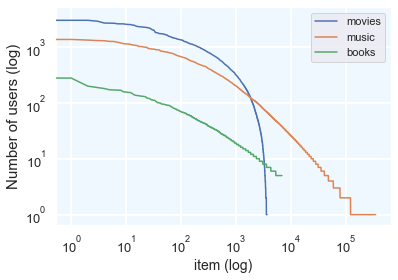

In [21]:
plot_data_distribution_together([item_dist_movies, item_dist_music, item_dist_books], item_list=["movies","music","books"])

# Gini coefficient

In [22]:
def plot_Lorenz_many(its_cdf, save = False, addition = ""):
    def f(t):
        return t
    for movs, cdf, name in its_cdf:
        plt.plot(movs*100, cdf*100, linewidth = 3,  label = "L(x) actual, "+name)
    plt.plot(movs*100, movs*100, linewidth = 3, color = "blue", label = "L(x) = x, distributional equality")
    plt.xlabel("100x% least consumed items")
    plt.ylabel("100y% of total amount of consumptions")
    #section = movs*100
    plt.legend()
    #plt.fill_between(section, f(section), color = "lightgrey")
    #plt.fill_between(movs*100, cdf*100, color = "gray")
    if save:
        plt.savefig('graphs/data_Lorenz'+addition+".png", bbox_inches='tight')
    plt.show(block=True)

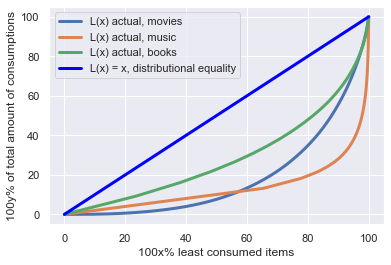

In [23]:
# GINI COEFFICIENT
GC_movs, movs, data_cdf_movs = calculate_gini_coefficient(item_dist_movies) # calculate gini coefficient
GC_mus, mus, data_cdf_mus = calculate_gini_coefficient(item_dist_music) # calculate gini coefficient
GC_boo, boo, data_cdf_boo = calculate_gini_coefficient(item_dist_books) # calculate gini coefficient
its_cdf = [[movs, data_cdf_movs, "movies"], [mus, data_cdf_mus, "music"], [boo,data_cdf_boo,"books"]] 

plot_Lorenz_many(its_cdf) # plot lorenz curve in data

In [24]:
GC_movs, GC_mus, GC_boo

(0.6335616037312073, 0.7362326993650111, 0.4303916552969049)

# GAPS

In [25]:
def calculate_popularity(df_events, top_item_dist, item_dist, num_users, user_col, item_col):
    pop_count = [] # number of top items per user
    user_hist = [] # user history sizes
    pop_fraq = [] # relative number of top items per user
    pop_item_fraq = [] # average popularity of items in user profiles
    i=0
    for u, df in df_events.groupby(user_col):
        no_user_items = len(set(df[item_col]))
        no_user_pop_items = len(set(df[item_col]) & set(top_item_dist.index))
        pop_count.append(no_user_pop_items)
        user_hist.append(no_user_items) 
        pop_fraq.append(no_user_pop_items / no_user_items)
        user_pop_item_fraq = sum(item_dist[df[item_col]] / num_users) / no_user_items
        pop_item_fraq.append(user_pop_item_fraq)
        i+=1
        if i%1000==0:
            print(i)
    return pop_count,user_hist,pop_fraq, pop_item_fraq

In [26]:
def calculate_popularity_for_music(df_events, top_item_dist, item_dist, num_users, user_col, item_col, low_users, medium_users, high_users):
    pop_count = [] # number of top items per user
    user_hist = [] # user history sizes
    pop_fraq = [] # relative number of top items per user
    pop_item_fraq = [] # average popularity of items in user profiles
    low_profile_size = 0
    low_gap = 0
    medium_profile_size = 0
    medium_gap = 0
    high_profile_size = 0
    high_gap = 0
    low_ratio = 0
    medium_ratio = 0
    high_ratio = 0
    
    i=0
    for u, df in df_events.groupby(user_col):
        no_user_items = len(set(df[item_col]))
        no_user_pop_items = len(set(df[item_col]) & set(top_item_dist.index))
        pop_count.append(no_user_pop_items)
        user_hist.append(no_user_items) 
        pop_fraq.append(no_user_pop_items / no_user_items)
        user_pop_item_fraq = sum(item_dist[df[item_col]] / num_users) / no_user_items
        pop_item_fraq.append(user_pop_item_fraq)
    
        if u in low_users.index: # get user group-specific values
            low_profile_size += no_user_items
            low_gap += user_pop_item_fraq
            low_ratio += no_user_pop_items / no_user_items
        elif u in medium_users.index:
            medium_profile_size += no_user_items
            medium_gap += user_pop_item_fraq
            medium_ratio += no_user_pop_items / no_user_items
        else:
            high_profile_size += no_user_items
            high_gap += user_pop_item_fraq
            high_ratio += no_user_pop_items / no_user_items
        i+=1
        if i%1000==0:
            print(i)
    low_profile_size /= len(low_users)
    medium_profile_size /= len(medium_users)
    high_profile_size /= len(high_users)
    low_ratio /= len(low_users)
    medium_ratio /= len(medium_users)
    high_ratio /= len(high_users)
    low_gap /= len(low_users)
    medium_gap /= len(medium_users)
    high_gap /= len(high_users)
  
    return pop_count,user_hist,pop_fraq, pop_item_fraq, low_profile_size, medium_profile_size, high_profile_size, low_gap, medium_gap, high_gap, low_ratio, medium_ratio, high_ratio

In [27]:
def read(low_user_file, medium_user_file, high_user_file):
    low_users = pd.read_csv(low_user_file, sep=',').set_index('user_id')
    medium_users = pd.read_csv(medium_user_file, sep=',').set_index('user_id')
    high_users = pd.read_csv(high_user_file, sep=',').set_index('user_id')
    no_users = len(low_users) + len(medium_users) + len(high_users)
    print('No. of users: ' + str(no_users))
    
    mainstreaminess = "M_global_R_APC"
    
    print('Average mainstreaminess per user for low: ' + str(low_users[mainstreaminess].mean()))
    print('Average mainstreaminess per user for med: ' + str(medium_users[mainstreaminess].mean()))
    print('Average mainstreaminess per user for high: ' + str(high_users[mainstreaminess].mean()))
    return no_users, low_users, medium_users, high_users

In [28]:
def sort_user_dist(user_dist,pop_count, user_hist,pop_fraq,pop_item_fraq, by = "pop_fraq"):
    user_dist = user_dist.sort_index()
    user_dist_sorted = pd.DataFrame(data = user_dist)
    
    user_dist_sorted.columns = ["count"]
    
    user_dist_sorted["pop_count"] = pop_count
    user_dist_sorted["user_hist"] = user_hist
    user_dist_sorted["pop_fraq"] = pop_fraq
    user_dist_sorted["pop_item_fraq"] = pop_item_fraq
    
    user_dist_sorted = user_dist_sorted.sort_values(by=[by])
    return user_dist_sorted

def split(user_dist_sorted, top_fraction):
    low, med, high = np.split(user_dist_sorted, [int(top_fraction*len(user_dist_sorted)), int((1-top_fraction)*len(user_dist_sorted))])
    return low, med, high
def calculate_group_characteristics(low, med, high):
    low_profile_size = low.user_hist.mean()
    med_profile_size = med.user_hist.mean()
    high_profile_size = high.user_hist.mean()
    
    low_nr_users = len(low)
    med_nr_users = len(med)
    high_nr_users = len(high)
    
    low_GAP = low.pop_item_fraq.mean()
    med_GAP = med.pop_item_fraq.mean()
    high_GAP = high.pop_item_fraq.mean()
    
    return low_profile_size, med_profile_size, high_profile_size, low_nr_users, med_nr_users, high_nr_users, low_GAP, med_GAP, high_GAP

#### Books

In [29]:
pop_count_books,user_hist_books,pop_fraq_books, pop_item_fraq_books = calculate_popularity(df_events_books, 
                                                                                           top_item_dist_books, 
                                                                         item_dist_books, num_users_books, "user", 
                                                                                           "book")

1000
2000
3000
4000
5000
6000


In [30]:
user_dist_sorted_books = sort_user_dist(user_dist_books,
                                        pop_count_books,
                                        user_hist_books,
                                        pop_fraq_books,
                                        pop_item_fraq_books)
low_books, med_books, high_books = split(user_dist_sorted_books, top_fraction)
low_profile_size_books, med_profile_size_books, high_profile_size_books, low_nr_users_books, med_nr_users_books, high_nr_users_books, low_GAP_books, med_GAP_books, high_GAP_books = calculate_group_characteristics(low_books, med_books, high_books)

#### Movies

In [31]:
pop_count_movies,user_hist_movies,pop_fraq_movies, pop_item_fraq_movies = calculate_popularity(df_events_movies, 
                                                                                           top_item_dist_movies, 
                                                                         item_dist_movies, num_users_movies, "user", 
                                                                                           "movie")

1000
2000
3000
4000
5000
6000


In [32]:
user_dist_sorted_movies = sort_user_dist(user_dist_movies,
                                        pop_count_movies,
                                        user_hist_movies,
                                        pop_fraq_movies,
                                        pop_item_fraq_movies)
low_movies, med_movies, high_movies = split(user_dist_sorted_movies, top_fraction)
low_profile_size_movies, med_profile_size_movies, high_profile_size_movies, low_nr_users_movies, med_nr_users_movies, high_nr_users_movies, low_GAP_movies, med_GAP_movies, high_GAP_movies = calculate_group_characteristics(low_movies, med_movies, high_movies)

#### Music

In [33]:
low_user_file = "https://media.githubusercontent.com/media/SavvinaDaniil/UnfairnessOfPopularityBias/main/data/low_main_users.txt"
medium_user_file = "https://media.githubusercontent.com/media/SavvinaDaniil/UnfairnessOfPopularityBias/main/data/medium_main_users.txt"
high_user_file = "https://media.githubusercontent.com/media/SavvinaDaniil/UnfairnessOfPopularityBias/main/data/high_main_users.txt"

In [34]:
num_users_music, low_music, med_music, high_music= read(low_user_file, medium_user_file, high_user_file)

No. of users: 3000
Average mainstreaminess per user for low: 0.009333709599999998
Average mainstreaminess per user for med: 0.18199761010999999
Average mainstreaminess per user for high: 0.33798161341000005


In [35]:
pop_count_music,user_hist_music,pop_fraq_music, pop_item_fraq_music, low_profile_size_music, med_profile_size_music, high_profile_size_music, low_GAP_music, med_GAP_music, high_GAP_music, low_ratio_music, med_ratio_music, high_ratio_music = calculate_popularity_for_music(df_events_music, top_item_dist_music, item_dist_music, num_users_music, "user", "artist", low_music, med_music, high_music)

1000
2000
3000


### Overall

In [36]:
low_GAP_books*100, low_GAP_movies*100, low_GAP_music*100

(0.5166413401809171, 10.801591873335479, 4.963328792099549)

In [37]:
med_GAP_books*100, med_GAP_movies*100, med_GAP_music*100

(0.529382610214949, 15.697555736769992, 5.437111935948923)

In [38]:
high_GAP_books*100, high_GAP_movies*100, high_GAP_music*100

(0.49930200775344163, 20.907251963505036, 6.286028679778642)